# LXMERT 모델 활용하기
---

In [ ]:
- 이번에는 여러분들이 임의로 이미지를 하나 골라 봅시다.
- 이미지에 대해 3~5가지 정도 영어로 질문을 작성해 봅시다.
- STEP 1, 2에서 수행했던 내용을 본인이 고른 이미지에 대해 동일하게 수행하고, 결과를 비교해 봅시다.

## Step 1. VQA 데이터셋
---

In [1]:
from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

worksapce_path = '/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD20_VQA'

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(worksapce_path +'/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

print(torch.__version__)

1.8.1+cu111


- 모델준비

In [152]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)
print(len(objids))
print(objids[:30])  #1600개의 단어사전 중 30개만 출력

1600
['yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign,stopsign', 'cone', 'microwave,microwave oven', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator,fridge', 'ostrich', 'bathtub', 'blinds']


In [153]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])   #400개의 단어사전 중 30개만 출력

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


In [154]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


- 이미지 입력 데이터

In [5]:
# image
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [6]:
print(images)
print(sizes)

tensor([[[[  61.0199,   61.2689,   62.1015,  ...,   50.5607,   50.1444,
             50.0199],
          [  60.8955,   61.1445,   61.9771,  ...,   50.8094,   50.3931,
             50.2686],
          [  60.4793,   60.7282,   61.5609,  ...,   51.6420,   51.2256,
             51.1012],
          ...,
          [ -87.9801,  -88.0373,  -88.2285,  ...,   21.7716,   21.5466,
             21.4793],
          [ -87.9801,  -88.0891,  -88.4536,  ...,   21.9628,   21.9110,
             21.8955],
          [ -87.9801,  -88.1046,  -88.5209,  ...,   22.0199,   22.0199,
             22.0199]],

         [[  48.0535,   48.4269,   49.6759,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.9291,   48.2871,   49.4843,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.5129,   47.8190,   48.8429,  ...,   41.5943,   41.1780,
             41.0535],
          ...,
          [ -99.9465,  -99.9364,  -99.9026,  ...,   13.8052,   13.5802,
             13.5129],
          [ -99.94

- 입력 이미지

In [8]:
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

### 모델 구성

VQA2 데이터셋을 활용하여 학습킨 모델을 사용

#### F-RCNN

In [10]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj1/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [11]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

- 모델 테스트

In [13]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [14]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.0372e+02, 1.3613e+02, 2.2735e+02, 1.6974e+02],
         [8.4005e+01, 1.1941e+02, 2.4814e+02, 1.7585e+02],
         [0.0000e+00, 8.1354e+01, 3.2642e+02, 2.6568e+02],
         [3.8475e+02, 3.7221e+01, 4.9974e+02, 3.3300e+02],
         [2.9875e+01, 0.0000e+00, 4.3054e+02, 1.3465e+02],
         [1.5929e+02, 9.1682e+01, 3.7275e+02, 2.4955e+02],
         [6.7672e-01, 2.4750e+02, 2.7701e+02, 3.3300e+02],
         [1.6578e+02, 1.2526e+02, 3.4723e+02, 2.1946e+02],
         [0.0000e+00, 7.1275e+01, 2.1836e+02, 3.0790e+02],
         [5.2669e+01, 1.7062e+00, 2.6646e+02, 1.8314e+02],
         [6.1805e+01, 2.4761e+02, 4.2838e+02, 3.3299e+02],
         [1.2076e+01, 1.1892e+02, 3.6657e+02, 3.0462e+02],
         [1.9641e+02, 1.0624e+02, 3.5971e+02, 1.9710e+02],
         [9.1356e+01, 1.1064e+02, 4.1889e+02, 2.8040e+02],
         [1.2139e+02, 1.0626e+01, 4.8306e+02, 1.6577e+02],
         [3.0271e+02, 1.0307e+02, 3.2805e+02, 1.2879e+02],
         [2.9658e+02, 5.5949e+00, 4.9991e+02, 2.7482e+02

- roi features 확인

In [16]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[2.4822e-03, 2.3580e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.3088e+00],
         [2.6639e-01, 1.0124e+00, 0.0000e+00,  ..., 9.0339e-04,
          1.5285e-02, 3.0090e+00],
         [6.0975e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0956e-01,
          2.5223e-01, 1.7357e+00],
         ...,
         [7.9118e-01, 2.3213e-01, 0.0000e+00,  ..., 2.2883e-02,
          7.2807e-03, 6.4609e-01],
         [0.0000e+00, 1.4173e+00, 0.0000e+00,  ..., 0.0000e+00,
          2.0937e+00, 1.9630e+00],
         [1.0801e+00, 8.3446e-01, 0.0000e+00,  ..., 1.2504e-02,
          3.0912e-01, 6.6703e-01]]])
-------------
torch.Size([1, 36, 2048])


- 시각화

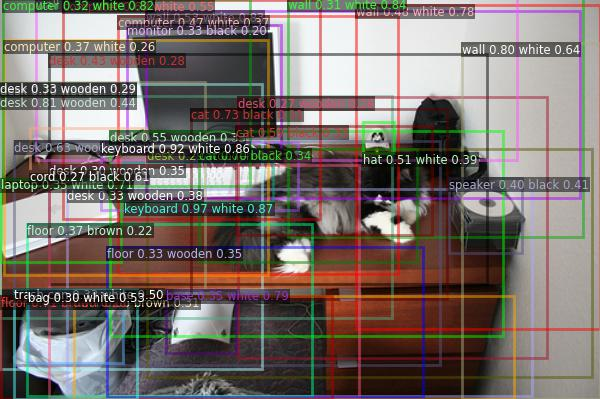

In [17]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

- feature 추출

In [18]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

#### LxmertTokenizer

- tokenizer 정의

In [19]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

- 테스트

In [20]:
test_question = ["What is the color of the table?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [21]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2054, 2003, 1996, 3609, 1997, 1996, 2795, 1029,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


#### LXMERT pretrained model

In [22]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

- 테스트

In [23]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

In [25]:
len(output_vqa["question_answering_score"][0])

3129

In [30]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa.numpy()[0]

2594

In [32]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown


### 질문 답하기

In [33]:
test_questions_for_url = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

In [188]:
def get_inputs(qeustion):
    return lxmert_tokenizer([qeustion],
                            padding="max_length",
                            max_length=20,
                            truncation=True,
                            return_token_type_ids=True,
                            return_attention_mask=True,
                            add_special_tokens=True,
                            return_tensors="pt")

In [189]:
def get_output(lxmert, inputs, features, normalized_boxes):
    return lxmert(input_ids=inputs.input_ids,
                  attention_mask=inputs.attention_mask,
                  visual_feats=features,
                  visual_pos=normalized_boxes,
                  token_type_ids=inputs.token_type_ids,
                  output_attentions=False)

In [54]:
for q in test_questions_for_url:
    inputs = get_inputs(q)
    output_vqa = get_output(lxmert_vqa,  inputs, features)
    
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    
    print("Question:", q)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa], "\n")

Question: Where is the cat?
prediction from LXMERT VQA: desk 

Question: What is near the disk?
prediction from LXMERT VQA: cat 

Question: What is the color of the table?
prediction from LXMERT VQA: brown 

Question: What is the color of the cat?
prediction from LXMERT VQA: black and white 

Question: What is the shape of the monitor?
prediction from LXMERT VQA: rectangle 

Question: What is the color of the keyboard?
prediction from LXMERT VQA: white 



## Step 2. GQA 데이터셋
---

### 모델 구성

In [36]:
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [155]:
gqa_answers = utils.get_data(GQA_URL)
print(len(gqa_answers))
print(gqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

1842
['cat food', 'elephant', 'gloves', 'football', 'dock', 'shops', 'water', 'light blue', 'chair', 'players', 'tourist', 'magnet', 'railroad', 'ski lift', 'mirror', 'leggings', 'hurdle', 'shuttle', 'wildflowers', 'flowers', 'cooking pot', 'pipe', 'swan', 'girl', 'celery', 'brown', 'ambulance', 'steps', 'power line', 'asphalt']


### 질문 답하기

In [55]:
for q in test_questions_for_url:
    inputs = get_inputs(q)
    output_gqa = get_output(lxmert_gqa,  inputs, features)
    
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    
    print("Question:", q)
    print("prediction from LXMERT VQA:", gqa_answers[pred_gqa], "\n")

Question: Where is the cat?
prediction from LXMERT VQA: desk 

Question: What is near the disk?
prediction from LXMERT VQA: can 

Question: What is the color of the table?
prediction from LXMERT VQA: brown 

Question: What is the color of the cat?
prediction from LXMERT VQA: black 

Question: What is the shape of the monitor?
prediction from LXMERT VQA: square 

Question: What is the color of the keyboard?
prediction from LXMERT VQA: white 



## Step 3. 임의의 이미지를 선정하여 모델 비교
---

### 질의응답 수행 함수 정의

In [193]:
def qa(URL, questions):
    images, sizes, scales_yx = image_preprocess(URL)
    output_dict = frcnn(
            images, 
            sizes, 
            scales_yx=scales_yx, 
            padding="max_detections",
            max_detections=frcnn_cfg.max_detections,
            return_tensors="pt"
        )
    frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

    frcnn_visualizer.draw_boxes(
        output_dict.get("boxes"),
        output_dict.pop("obj_ids"),
        output_dict.pop("obj_probs"),
        output_dict.pop("attr_ids"),
        output_dict.pop("attr_probs"),
    )
    showarray(frcnn_visualizer._get_buffer())

    normalized_boxes = output_dict.get("normalized_boxes")
    features = output_dict.get("roi_features")
    
    q_and_a = [[q] for q in questions]
    
    for i, q in enumerate(questions):
        inputs = get_inputs(q)
        output_vqa = get_output(lxmert_vqa,  inputs, features, normalized_boxes)
        pred_vqa = output_vqa["question_answering_score"].argmax(-1)
        q_and_a[i].append(vqa_answers[pred_vqa])
        
    for i, q in enumerate(questions):
        inputs = get_inputs(q)
        output_gqa = get_output(lxmert_gqa,  inputs, features, normalized_boxes)
        pred_gqa = output_gqa["question_answering_score"].argmax(-1)
        q_and_a[i].append(gqa_answers[pred_gqa])
        
    return pd.DataFrame(q_and_a, columns=['Question', 'VQA', 'GQA'])

### 질문 준비

In [195]:
URLS = [
    'https://i.pinimg.com/564x/09/03/28/090328106ddc1bab815aaa27553906fb.jpg',
    'https://i.pinimg.com/564x/05/9c/26/059c26d0c280d0a9d4af1a4f17e01f1c.jpg',
    'https://i.pinimg.com/564x/eb/92/0c/eb920c08a23efc142d419b6ee4c3bdaf.jpg'
]

q_1 = [
    "Where is the vase?",
    "What is near the bed?",
    "What is the color of the flowers?",
    "What is the color of the vase?",
    "What is the shape of the map?",
    "What is the color of the bed?",
]

q_2 = [
    "Where is the flower?",
    "What is near the lamp?",
    "What is the color of the candle?",
    "What is on the table?",
    "What is the color of the pillow?",
]

q_3 = [
    "What is the color of the blanket?",
    "What is the color of the sky?",
    "What is near the blanket?"
]

### 질의응답 수행

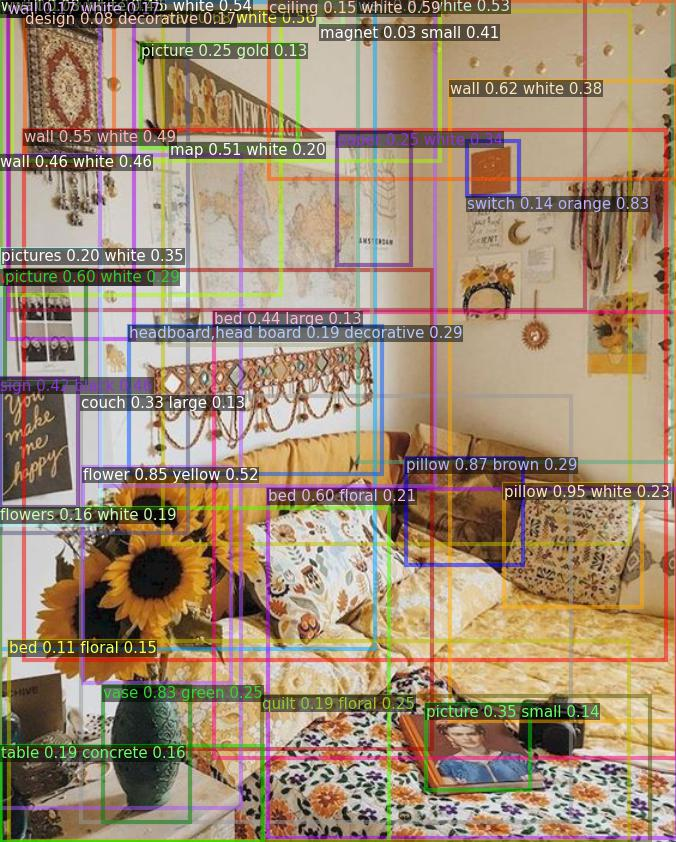

,Question,VQA,GQA
0,Where is the vase?,table,floor
1,What is near the bed?,wall,curtain
2,What is the color of the flowers?,yellow,yellow
3,What is the color of the vase?,green,green
4,What is the shape of the map?,rectangle,rectangular
5,What is the color of the bed?,yellow,brown


In [196]:
qa(URLS[0], q_1)

- VQA가 더 좋은 결과를 보였다.
    - 근거 : Where is the vase?, What is the color of the bed?	

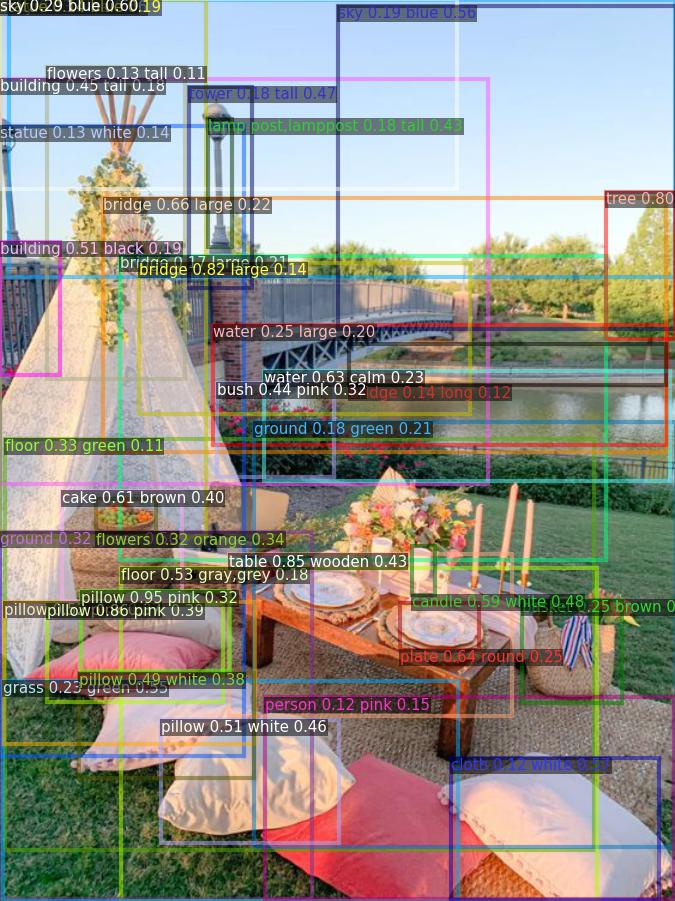

,Question,VQA,GQA
0,Where is the flower?,bridge,lawn
1,What is near the lamp?,table,decoration
2,What is the color of the candle?,white,white
3,What is on the table?,candles,candle
4,What is the color of the pillow?,pink,pink


In [197]:
qa(URLS[1], q_2)

- GQA가 더 좋은 결과를 보였다.
    - 근거 : Where is the flower?, What is near the lamp?	

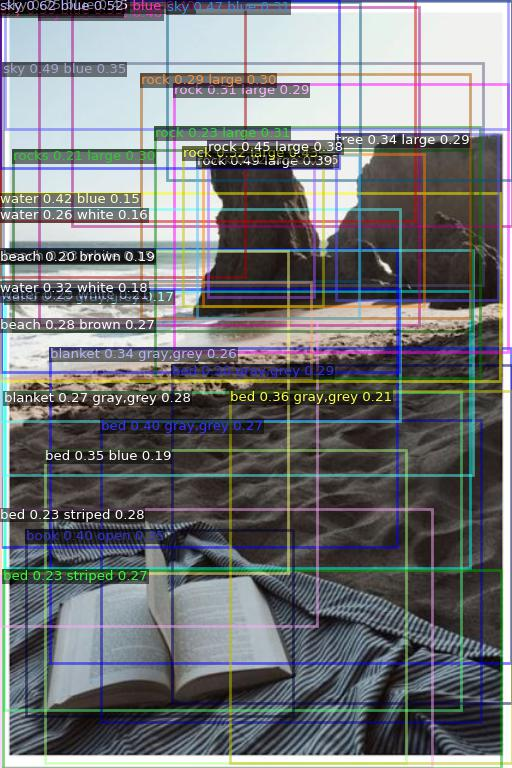

,Question,VQA,GQA
0,What is the color of the blanket?,plaid,gray
1,What is the color of the sky?,blue,blue
2,What is near the blanket?,book,book


In [198]:
qa(URLS[2], q_3)

- VQA가 더 좋은 결과를 보였다.
    - 근거 : What is the color of the blanket?	

### 결론

질문사항과 입력 이미지에 따라서 더 좋은 성능을 보이는 모델이 달랐다.